# TensorFlow2 DenseNet-LSTM (RGB)

## 1.导入数据
使用BROOK数据集 

In [52]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [53]:
txt_file = 'sc/train23.txt'
# txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspaths.append(filename)
        speeds.append(int(speed))
    
y_train = np.array(speeds)



In [54]:
max_unit = np.max(y_train)

In [55]:
txt_file = 'sc/test23.txt'
# txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspath2.append(filename)
        speeds.append(int(speed))
y_test = np.array(speeds)
        

In [56]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [57]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [58]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [59]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [60]:
from tensorflow.keras import layers
model = keras.Sequential()

In [61]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [62]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(img_input)
lstm_layer = layers.LSTM(50, return_sequences=False)(reshape)
dense2 = layers.Dense(64)(lstm_layer)

In [63]:
merged_layer = layers.concatenate([dense1, dense2])
# merged_layer = dense1
outt = layers.Dense(max_unit+1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 1, 1, 1920)   18321984    input_8[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1024, 3)      0           input_8[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1920)         0           densenet201[0][0]                
_______________________________________________________________________________________

In [66]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
240/240 [==============================] - 151s 631ms/step - loss: 0.5771 - accuracy: 0.7899 - val_loss: 2.8586 - val_accuracy: 0.4084
Epoch 2/200
240/240 [==============================] - 145s 606ms/step - loss: 0.5318 - accuracy: 0.8028 - val_loss: 6.0247 - val_accuracy: 0.1717
Epoch 3/200
240/240 [==============================] - 145s 603ms/step - loss: 0.5050 - accuracy: 0.8111 - val_loss: 3.7008 - val_accuracy: 0.3732
Epoch 4/200
240/240 [==============================] - 141s 588ms/step - loss: 0.4793 - accuracy: 0.8233 - val_loss: 1.8207 - val_accuracy: 0.5211
Epoch 5/200
240/240 [==============================] - 140s 585ms/step - loss: 0.4578 - accuracy: 0.8313 - val_loss: 6.9662 - val_accuracy: 0.2150
Epoch 6/200
240/240 [==============================] - 139s 580ms/step - loss: 0.4134 - accuracy: 0.8431 - val_loss: 2.1646 - val_accuracy: 0.4470
Epoch 7/200
240/240 [==============================] - 138s 577ms/step - loss: 0.4261 - accuracy: 0.8453 - val_loss: 4

240/240 [==============================] - 151s 631ms/step - loss: 0.1412 - accuracy: 0.9549 - val_loss: 1.1761 - val_accuracy: 0.7234
Epoch 57/200
240/240 [==============================] - 150s 624ms/step - loss: 0.0882 - accuracy: 0.9691 - val_loss: 1.7474 - val_accuracy: 0.6527
Epoch 58/200
240/240 [==============================] - 144s 601ms/step - loss: 0.0958 - accuracy: 0.9684 - val_loss: 1.2758 - val_accuracy: 0.7294
Epoch 59/200
240/240 [==============================] - 144s 598ms/step - loss: 0.0845 - accuracy: 0.9717 - val_loss: 1.9338 - val_accuracy: 0.6253
Epoch 60/200
240/240 [==============================] - 142s 593ms/step - loss: 0.0944 - accuracy: 0.9667 - val_loss: 1.3710 - val_accuracy: 0.7015
Epoch 61/200
240/240 [==============================] - 142s 591ms/step - loss: 0.1210 - accuracy: 0.9617 - val_loss: 2.1000 - val_accuracy: 0.5830
Epoch 62/200
240/240 [==============================] - 143s 597ms/step - loss: 0.0910 - accuracy: 0.9683 - val_loss: 1.2306 

240/240 [==============================] - 133s 554ms/step - loss: 0.0788 - accuracy: 0.9755 - val_loss: 3.3136 - val_accuracy: 0.5282
Epoch 112/200
240/240 [==============================] - 133s 553ms/step - loss: 0.0457 - accuracy: 0.9862 - val_loss: 1.6042 - val_accuracy: 0.6808
Epoch 113/200
240/240 [==============================] - 133s 554ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 1.5576 - val_accuracy: 0.7093
Epoch 114/200
240/240 [==============================] - 133s 554ms/step - loss: 0.0346 - accuracy: 0.9901 - val_loss: 0.9324 - val_accuracy: 0.8053
Epoch 115/200
240/240 [==============================] - 133s 554ms/step - loss: 0.0564 - accuracy: 0.9836 - val_loss: 1.4358 - val_accuracy: 0.7401
Epoch 116/200
240/240 [==============================] - 133s 555ms/step - loss: 0.0486 - accuracy: 0.9845 - val_loss: 1.8954 - val_accuracy: 0.6568
Epoch 117/200
240/240 [==============================] - 133s 556ms/step - loss: 0.0630 - accuracy: 0.9791 - val_loss: 3

240/240 [==============================] - 135s 562ms/step - loss: 0.0795 - accuracy: 0.9763 - val_loss: 2.7049 - val_accuracy: 0.6109
Epoch 167/200
240/240 [==============================] - 135s 562ms/step - loss: 0.0395 - accuracy: 0.9874 - val_loss: 1.2673 - val_accuracy: 0.7711
Epoch 168/200
240/240 [==============================] - 135s 562ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 1.2954 - val_accuracy: 0.7508
Epoch 169/200
240/240 [==============================] - 135s 561ms/step - loss: 0.0291 - accuracy: 0.9920 - val_loss: 1.1019 - val_accuracy: 0.7912
Epoch 170/200
240/240 [==============================] - 135s 561ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 5.0592 - val_accuracy: 0.4428
Epoch 171/200
240/240 [==============================] - 135s 563ms/step - loss: 0.0351 - accuracy: 0.9888 - val_loss: 1.6410 - val_accuracy: 0.7351
Epoch 172/200
240/240 [==============================] - 135s 562ms/step - loss: 0.0285 - accuracy: 0.9929 - val_loss: 0

In [67]:
model.evaluate(x=x_test, y=y_test,verbose=1)

120/120 [==============================] - 10s 82ms/step - loss: 1.1323 - accuracy: 0.7821


[1.132333755493164, 0.782098114490509]

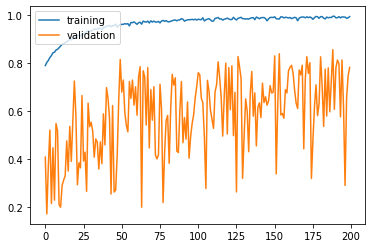

In [68]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [69]:
np.max(history2.history['accuracy'])

0.9952374696731567

In [70]:
np.max(history2.history['val_accuracy'])

0.8562108278274536